# Predicciones temporales con modelos de IA

Dentro de este cuaderno de Jupyter se estudiarán distintos modelos de IA para llevar a cabo predicciones sobre series temporales. Los distintos apartados que se presentarán en el cuaderno son:

 1. Carga de librerias, modelos y herramientas a utilizar.
 2. Análisis y preprocesamiento de datos.
 3. Creación y estudio de predicciones con TimeGPT.
 4. Creación y estudio de predicciones con Prophet (NeuroProphet).
 5. Creación y estudio de predicciones con LSMT.
 6. Análisis de resultados y modelo a usar.

## 1. Carga de librerias, modelos y herramientas

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps

Para este primer acercamiento se tomará como referencia los datos del sensor Suntracer localizado en el Edificio Centro de Investigaciones Tecnológicas de la Información y las Comunicaciones.

In [109]:
# Load the data
data = pd.read_csv('data/wot-data-db.interactions-datas_suntracer_temperature.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
#Rename the column of data value to temperature
data.rename(columns = {'data.value':'temperature (Cº)'}, inplace = True)

df = data[['timestamp', 'temperature (Cº)']]

df.head(15)

,timestamp,temperature (Cº)
0,2023-03-03 09:30:00,22.7
1,2023-03-03 09:31:00,22.2
2,2023-03-03 09:32:00,21.8
3,2023-03-03 09:33:00,22.1
4,2023-03-03 09:34:00,22.6
5,2023-03-03 09:35:00,22.7
6,2023-03-03 09:36:00,23.3
7,2023-03-03 09:37:00,23.9
8,2023-03-03 09:39:00,24.2
9,2023-03-03 09:40:00,24.3


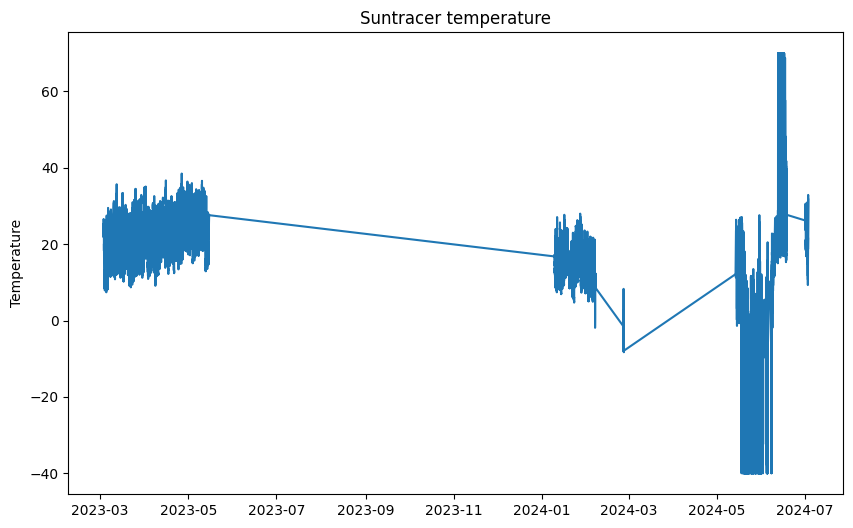

In [110]:
plt.figure(figsize=(10,6))
plt.plot(df['timestamp'], df['temperature (Cº)'])
plt.title('Suntracer temperature')
plt.ylabel('Temperature')
plt.show()

Los datos completos del Suntracer no son favorables a ser tratados directamente dentro del modelo debido a distintos problemas:
- Datos extremos y, probablemente, erróneos como temperaturas de -40º o 70º.
- Ausencia de datos por largos periodos temporales, como lo son del 2023-05-16 al 2024-01-09.

### Datos extremos

##### Temperaturas mínimas de -40º y máximas de 70º

In [111]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp,134665,2023-09-22 23:04:28.315598080,2023-03-03 09:30:00,2023-04-06 15:04:00,2023-05-10 02:02:00,2024-05-14 10:14:00,2024-07-03 09:18:00,NaN
temperature (Cº),134665.0,17.323239,-40.0,13.0,18.2,24.4,70.0,15.474028


### Ausencia de datos por largos periodos

In [112]:
# Dataframe auxiliar para mostrar datos faltantes
test_missing_data = df.copy()
test_missing_data.set_index('timestamp', inplace=True)

##### 16/5/2023 - 8/1/2024

In [113]:
missing_6_months = test_missing_data['2023-05-16':'2024-01-08']
missing_6_months.head()

,temperature (Cº)
timestamp,


##### 27/2/2024 - 13/5/2024

In [114]:
missing_3_months = test_missing_data['2024-02-27':'2024-05-13']
missing_3_months.head()

,temperature (Cº)
timestamp,


##### 19/6/2024 - 30/6/2024

In [115]:
missing_actual = test_missing_data['2024-06-19':'2024-06-30']
missing_actual.head()

,temperature (Cº)
timestamp,


Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [116]:
reduced_df = df[(df['timestamp'] >= '2023-03-01') & (df['timestamp'] <= '2023-05-15')]
reduced_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp,72237,2023-04-09 05:01:04.047510272,2023-03-03 09:30:00,2023-03-22 16:05:00,2023-04-08 21:59:00,2023-04-27 05:29:00,2023-05-15 00:00:00,NaN
temperature (Cº),72237.0,21.258107,7.4,16.1,20.9,26.2,38.5,6.039438


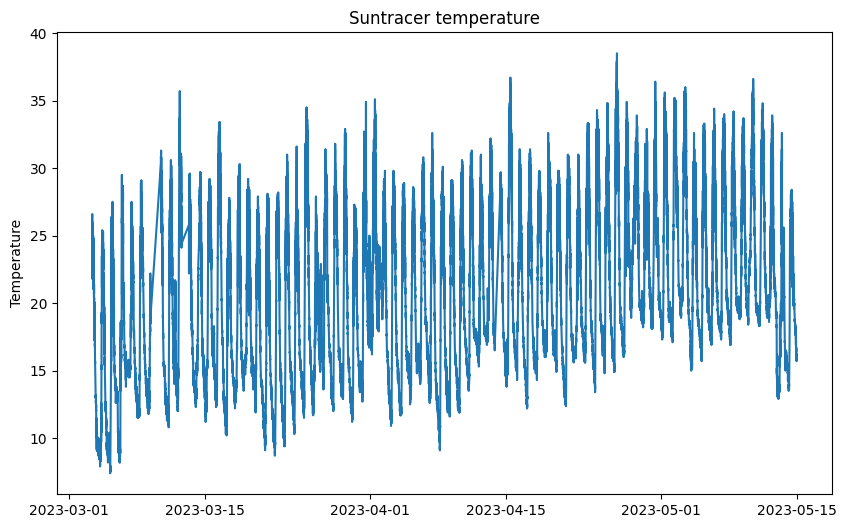

In [117]:
plt.figure(figsize=(10,6))
plt.plot(reduced_df['timestamp'], reduced_df['temperature (Cº)'])
plt.title('Suntracer temperature')
plt.ylabel('Temperature')
plt.show()

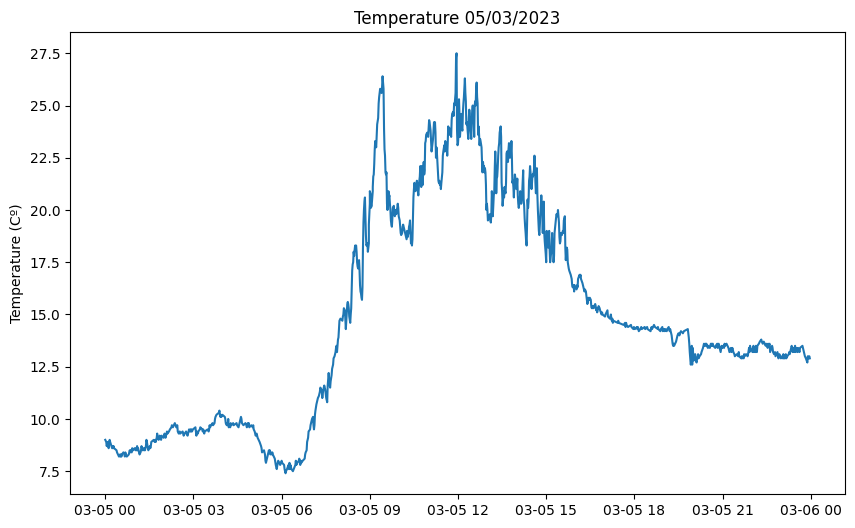

In [118]:
# Filter the data for the day 2023/03/05
filtered_data = df[df['timestamp'].dt.date == pd.to_datetime('2023-03-05').date()]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['timestamp'], filtered_data['temperature (Cº)'])
plt.title('Temperature 05/03/2023')
plt.ylabel('Temperature (Cº)')
plt.show()

Antes de continuar con la elaboración y análisis de los distintos modelos, es necesario completar un preprocesamiento de los datos. Esto supone tratar los valores duplicados para obtener un único valor a partir de su media además de añadir con interpolación los valores faltantes (hay minutos que no se encuentran disponible). Estudiaremos las consecuencias de la interpolación en completed_df.

### Registros duplicados

In [119]:
print('Número de registros duplicados:', reduced_df.duplicated(subset='timestamp').sum())
reduced_df = reduced_df.groupby('timestamp').mean().reset_index()
print('Número de registros duplicados:', reduced_df.duplicated(subset='timestamp').sum())

reduced_df.describe().transpose()

Número de registros duplicados: 491
Número de registros duplicados: 0


,count,mean,min,25%,50%,75%,max,std
timestamp,71746,2023-04-09 05:08:38.975831296,2023-03-03 09:30:00,2023-03-22 16:08:15,2023-04-08 22:15:30,2023-04-27 05:35:45,2023-05-15 00:00:00,NaN
temperature (Cº),71746.0,21.251211,7.4,16.1,20.9,26.2,38.5,6.037587


In [120]:
reduced_df.head(10)

,timestamp,temperature (Cº)
0,2023-03-03 09:30:00,22.7
1,2023-03-03 09:31:00,22.2
2,2023-03-03 09:32:00,21.8
3,2023-03-03 09:33:00,22.1
4,2023-03-03 09:34:00,22.6
5,2023-03-03 09:35:00,22.7
6,2023-03-03 09:36:00,23.3
7,2023-03-03 09:37:00,23.9
8,2023-03-03 09:39:00,24.2
9,2023-03-03 09:40:00,24.3


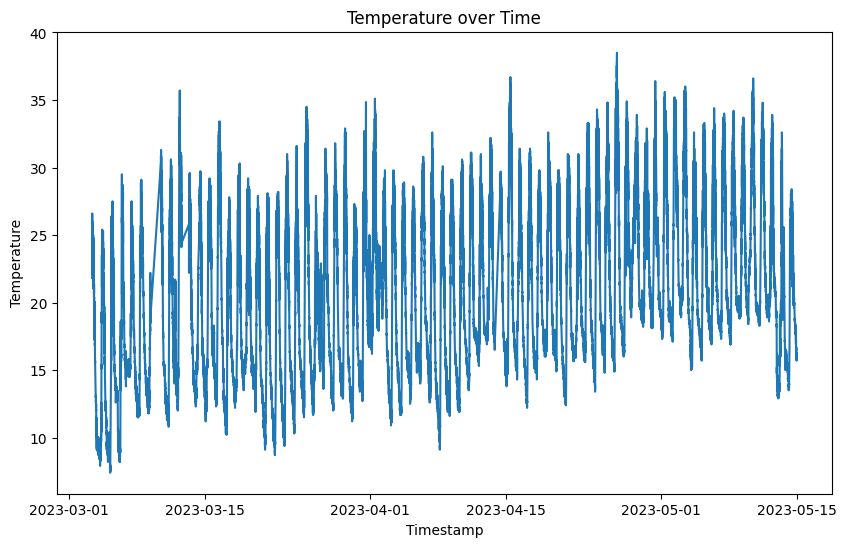

In [121]:
plt.figure(figsize=(10,6))
plt.plot(reduced_df['timestamp'], reduced_df['temperature (Cº)'])
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

### Interpolación de valores faltantes

In [122]:
print("Original data: ", len(reduced_df), "rows")
gaps = reduced_df[['timestamp', 'temperature (Cº)']]

# Adaptamos el dataset a las necesidades de la función fill_gaps
gaps.rename(columns={'timestamp': 'ds', 'temperature (Cº)': 'y'}, inplace=True)
gaps['ds'] = pd.to_datetime(gaps['ds'])
gaps['unique_id'] = 'suntracer_temperature'
gaps = gaps[['unique_id', 'ds', 'y']]
gaps.head()
completed_df = fill_gaps(gaps, freq='min')
print("Filled data: ", len(completed_df), "rows")

# Completamos los valores faltantes con la media de los valores anteriores y posteriores
completed_df['y'] = completed_df['y'].interpolate(method='linear', limit_direction='both')
completed_df.describe().transpose()

Original data:  71746 rows
Filled data:  104551 rows


,count,mean,min,25%,50%,75%,max,std
ds,104551,2023-04-08 16:44:59.999999488,2023-03-03 09:30:00,2023-03-21 13:07:30,2023-04-08 16:45:00,2023-04-26 20:22:30,2023-05-15 00:00:00,NaN
y,104551.0,20.388311,7.4,15.75,19.5,25.2,38.5,5.832544


In [123]:
completed_df.head(15)

,unique_id,ds,y
0,suntracer_temperature,2023-03-03 09:30:00,22.70
1,suntracer_temperature,2023-03-03 09:31:00,22.20
2,suntracer_temperature,2023-03-03 09:32:00,21.80
3,suntracer_temperature,2023-03-03 09:33:00,22.10
4,suntracer_temperature,2023-03-03 09:34:00,22.60
5,suntracer_temperature,2023-03-03 09:35:00,22.70
6,suntracer_temperature,2023-03-03 09:36:00,23.30
7,suntracer_temperature,2023-03-03 09:37:00,23.90
8,suntracer_temperature,2023-03-03 09:38:00,24.05
9,suntracer_temperature,2023-03-03 09:39:00,24.20


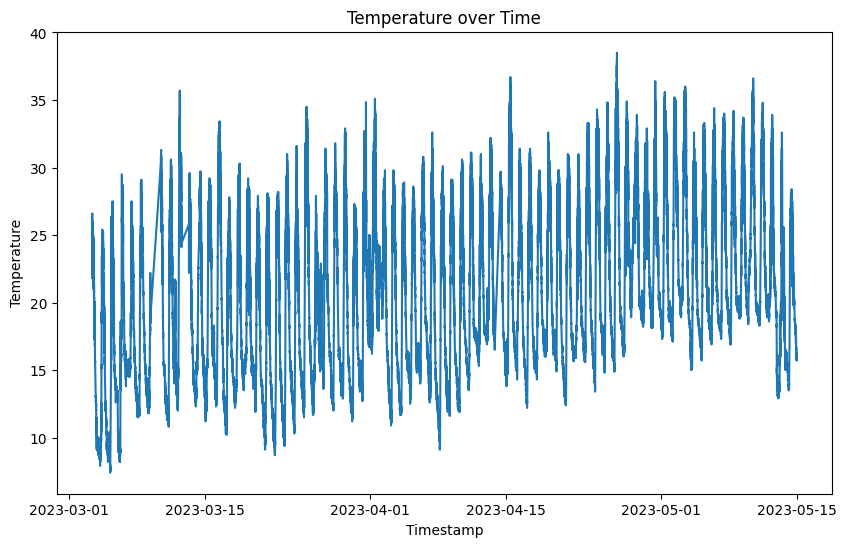

In [124]:
plt.figure(figsize=(10,6))
plt.plot(completed_df['ds'], completed_df['y'])
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

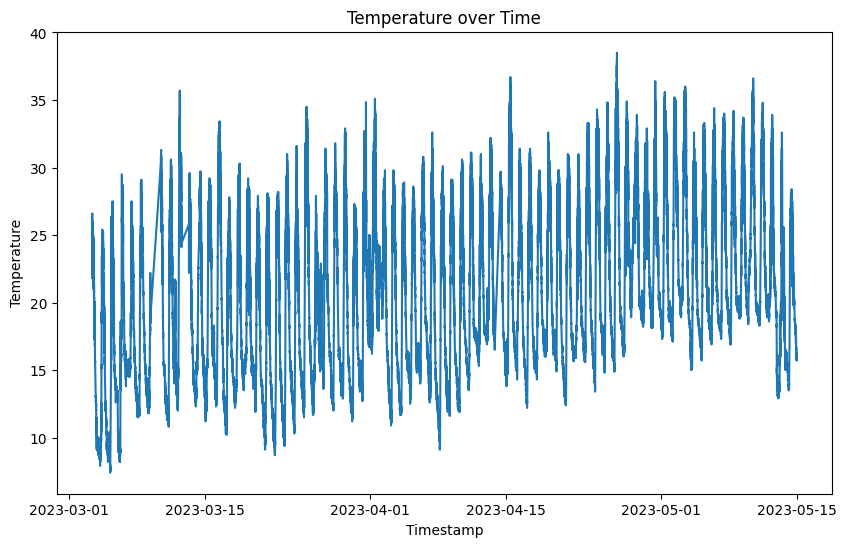

In [125]:
plt.figure(figsize=(10,6))
plt.plot(completed_df['ds'], completed_df['y'])
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

## 2. Creación y análsis del modelo con TimeGPT

La librería *nixtla* nos ofrecerá las utilidades necesarias para trabajar con TimeGPT. Además de esto, será necesario contar con una clave para hacer uso de sus servicios. Estudiaremos su funcionamiento con los datos tratados y con los datos sin tratar para comprobar la mejor solución.

In [126]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key='nixtla-tok-0Xy1KrijueISj5UTfxyGuceKmM8KuLVGO1b92Xs1i3DZB0bUvmr2CjtSqjHn9UlTQokrx3Wl8C7dnOlE')
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

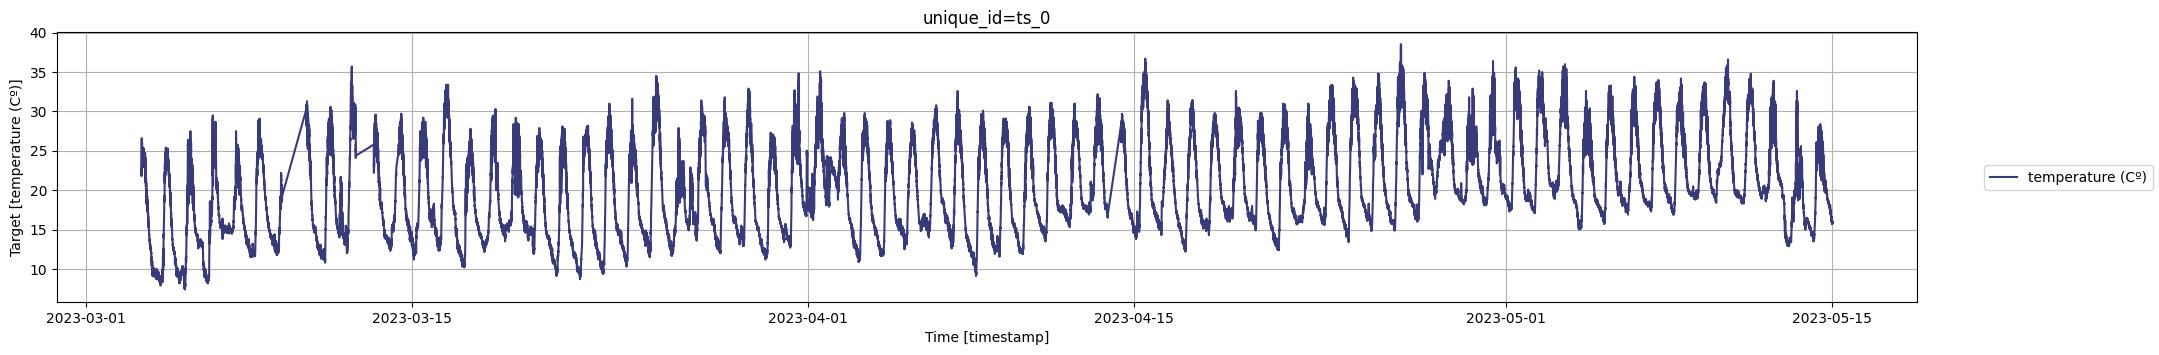

In [127]:
nixtla_client.plot(reduced_df,time_col='timestamp', target_col='temperature (Cº)')

Para poder llevar comparativas al final del cuaderno se llevará a cabo una separación de los datos entre datos de entrenamiento y datos de test o prueba. Los datos de entrenamiento corresponden al conjunto de datos que se utilizarán para entrenar al modelo, mientras que los datos de prueba se utilizarán para responder a la pregunta “¿Cómo de bien funciona nuestro modelo?”. 

En este caso se ha optado por dividir los datos en 80% para entrenamiento y 20% para pruebas. Debido a la dependencia temporal de los datos, la división de los datos se completará manteniendo el orden que presentan actualmente. Si se tuviese un dataset con 100 registros, la división propuesta asignaría los primeros 80 registros para el entrenamiento y los 20 registros restantes para las pruebas.

In [128]:
# Separación entre valores de entrenamiento y test
separation_grade = 0.2
test_rows = int(len(reduced_df)*separation_grade)
test_filled_rows = int(len(completed_df)*separation_grade)

# Dataset sin datos tratados
test = reduced_df.tail(test_rows)
train = reduced_df.apply(lambda x: x.iloc[:-test_rows]).reset_index(drop=True)

# Dataset con datos tratados
test_filled = completed_df.tail(test_filled_rows)
train_filled = completed_df.apply(lambda x: x.iloc[:-test_filled_rows]).reset_index(drop=True)

len(train), len(test), len(test_filled), len(train_filled)

(57397, 14349, 20910, 83641)

### Predicciones con los datos sin tratar

TimeGPT no permite llevar a cabo predicciones con valor de horizonte (h) elevado. Si se desea obtener predicciones de días con datos de cada minuto, el modelo no funcionara de forma óptima, siendo antes necesario un pretratamiento de los datos. Debido a ello, nos limitaremos, por ahora, a predicciones de hasta 2 horas en el futuro (120 minutos)

In [129]:
# Predicciones hasta el valor de longitud indicado (no funciona bien como consecuencia del alto valor del horizonte de predicción). Descomentar método para confirmar este hecho
#forecast = nixtla_client.forecast(
    #df=train, 
    #h=len(test), 
    #freq='min',
    #finetune_steps=20,
    #finetune_loss='mae', 
    #time_col='timestamp', 
    #target_col='temperature (Cº)')

In [130]:
forecast = nixtla_client.forecast(
    df=train, 
    h=120, 
    freq='min',
    finetune_steps=10,
    finetune_loss='mae', 
    time_col='timestamp', 
    target_col='temperature (Cº)',
    model='timegpt-1-long-horizon')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Comprobamos los resultados de la predicción 120 minutos en el futuro.

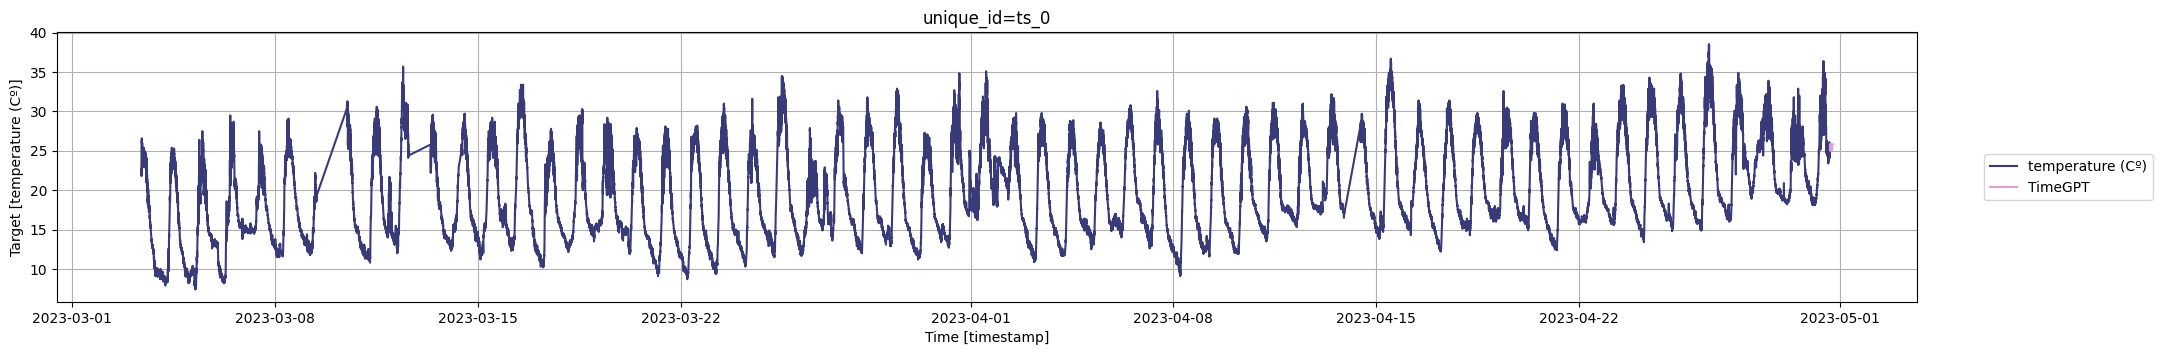

In [131]:
nixtla_client.plot(train, forecast, time_col='timestamp', target_col='temperature (Cº)')

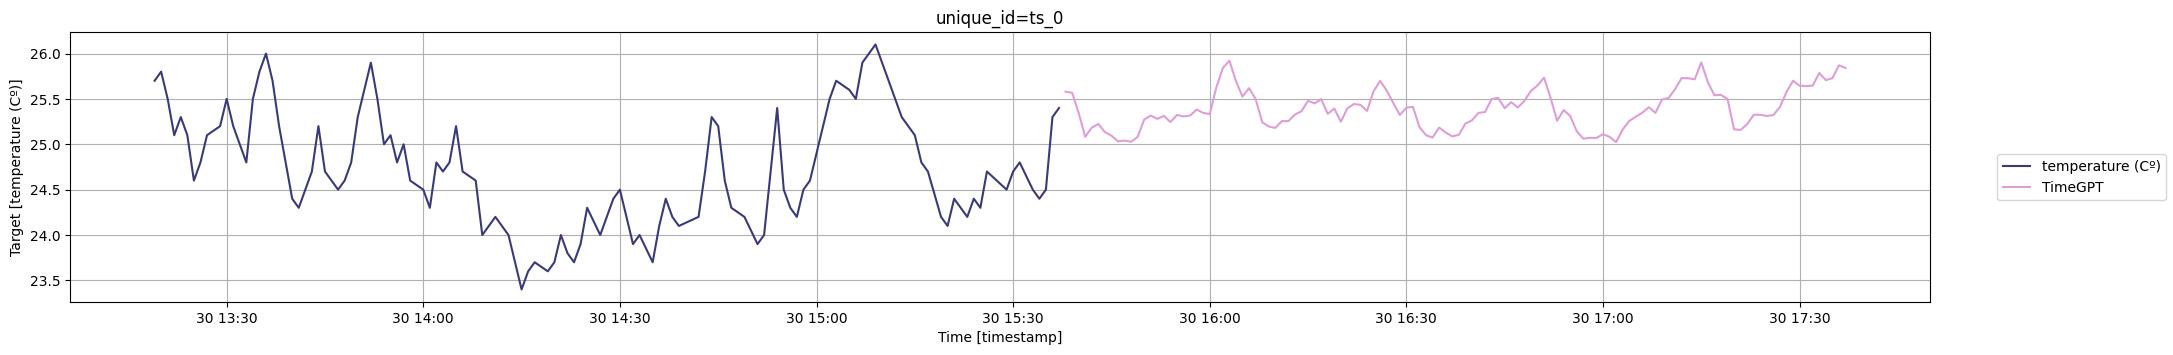

In [132]:
nixtla_client.plot(train, forecast, time_col='timestamp', target_col='temperature (Cº)', max_insample_length=120)

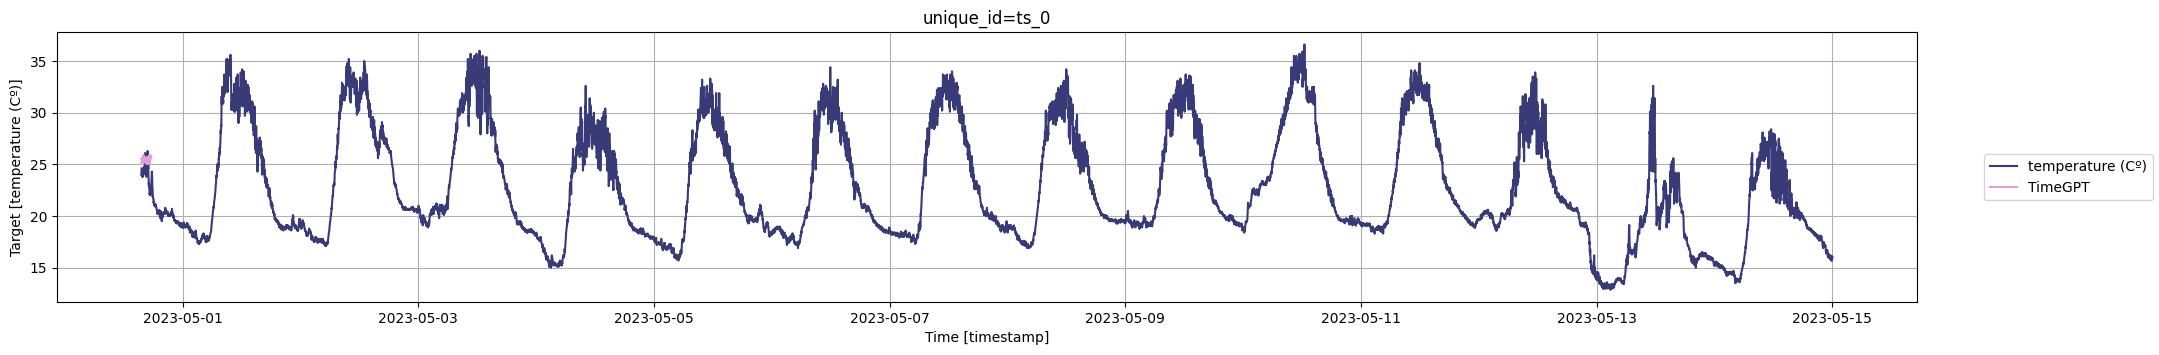

In [133]:
nixtla_client.plot(test, forecast, time_col='timestamp', target_col='temperature (Cº)')

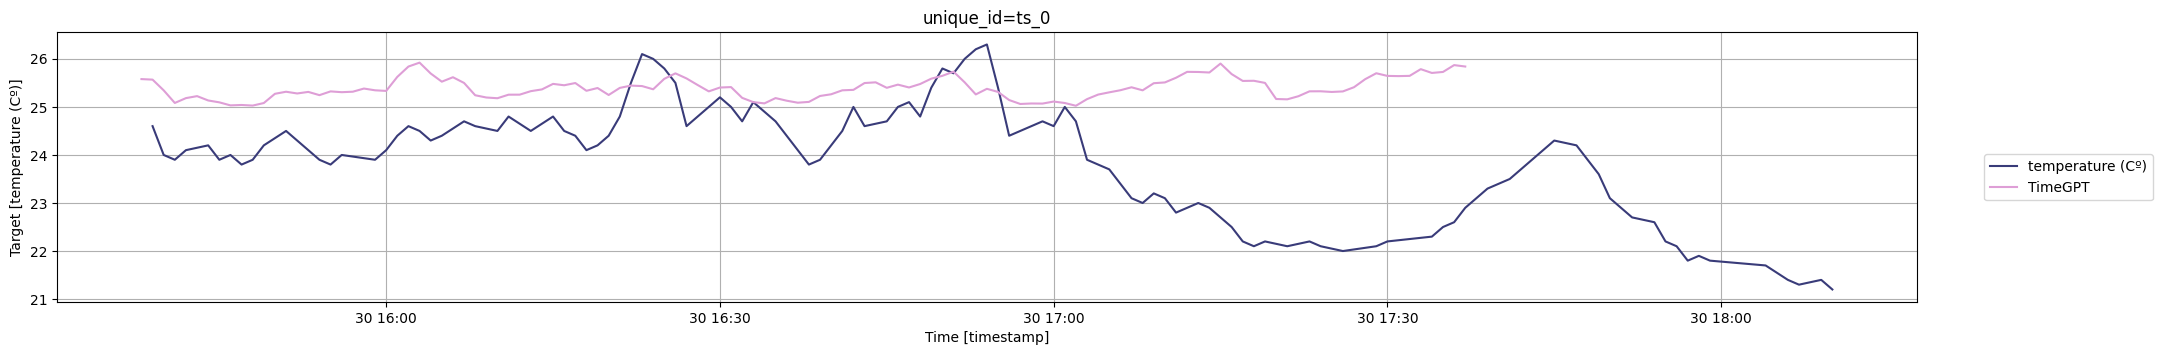

In [134]:
nixtla_client.plot(test[:120], forecast, time_col='timestamp', target_col='temperature (Cº)')

TimeGPT también nos ofrece la posibilidad de detectar anomalías dentro de los datos. Ejecutaremos el método para ver que ofrece la función.

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


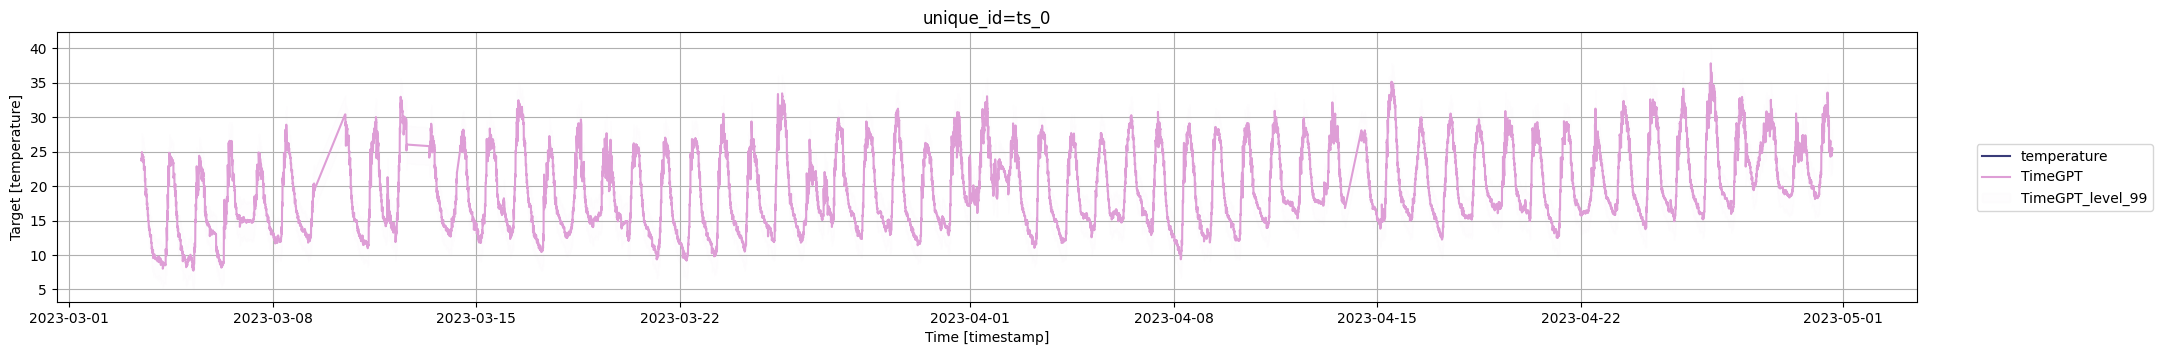

In [135]:
anomalies_df = nixtla_client.detect_anomalies(train, time_col='timestamp', target_col='temperature (Cº)', freq='min')
nixtla_client.plot(train, anomalies_df, time_col='timestamp', target_col='temperature')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


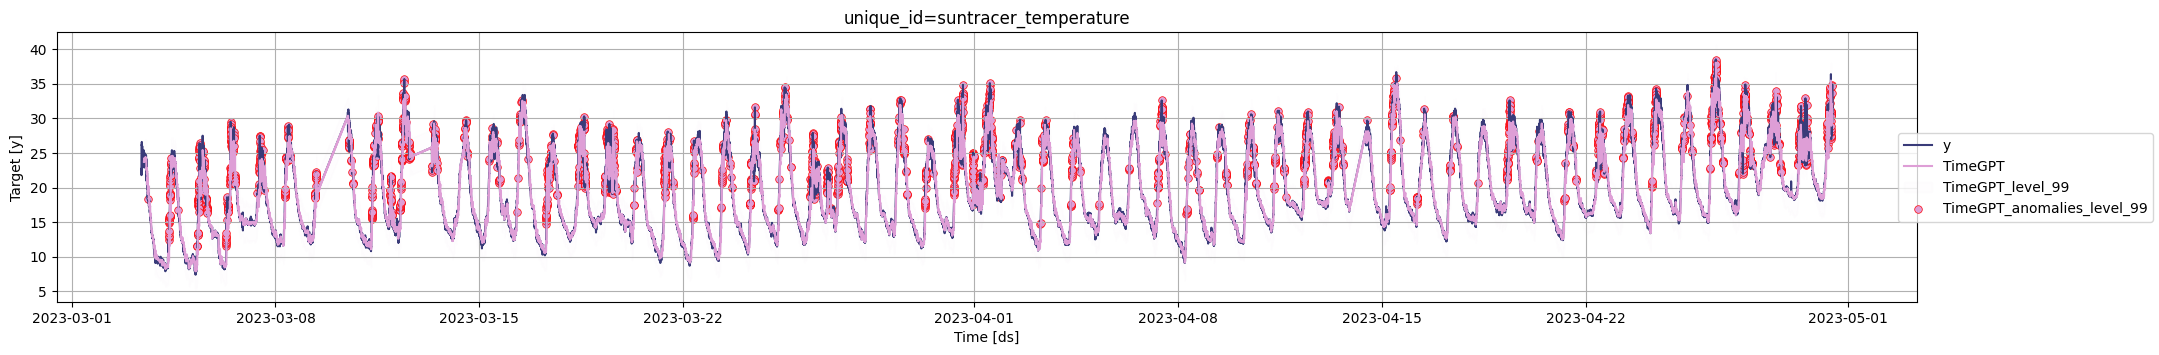

In [136]:
anomalies_completed_df = nixtla_client.detect_anomalies(train_filled, freq='min')
nixtla_client.plot(train_filled, anomalies_completed_df)

### Predicciones con los datos tratados

In [137]:
forecast_without_gaps = nixtla_client.forecast(
    df = train_filled,
    h = 120,
    finetune_steps=10,
    finetune_loss='mae',
    time_col='ds',
    target_col='y',
    model='timegpt-1-long-horizon'
    )

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [138]:
forecast_without_gaps.head()

,unique_id,ds,TimeGPT
0,suntracer_temperature,2023-04-30 11:31:00,31.443863
1,suntracer_temperature,2023-04-30 11:32:00,31.227592
2,suntracer_temperature,2023-04-30 11:33:00,31.167532
3,suntracer_temperature,2023-04-30 11:34:00,31.194633
4,suntracer_temperature,2023-04-30 11:35:00,31.304852


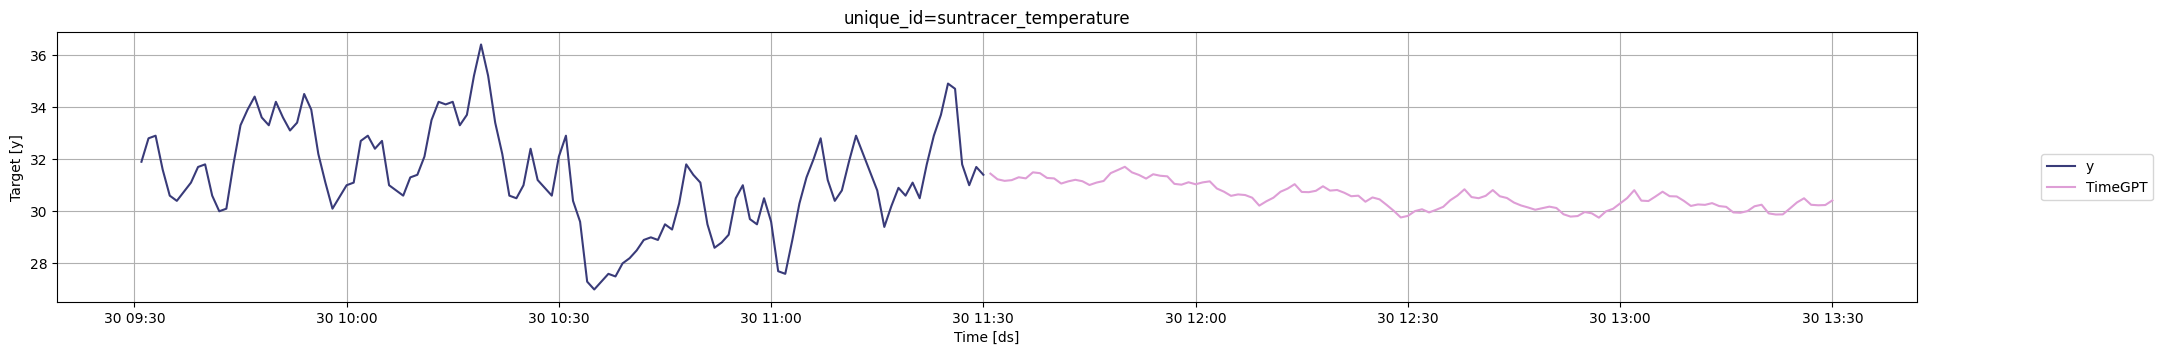

In [139]:
nixtla_client.plot(train_filled, forecast_without_gaps, time_col='ds', target_col='y', max_insample_length=120)

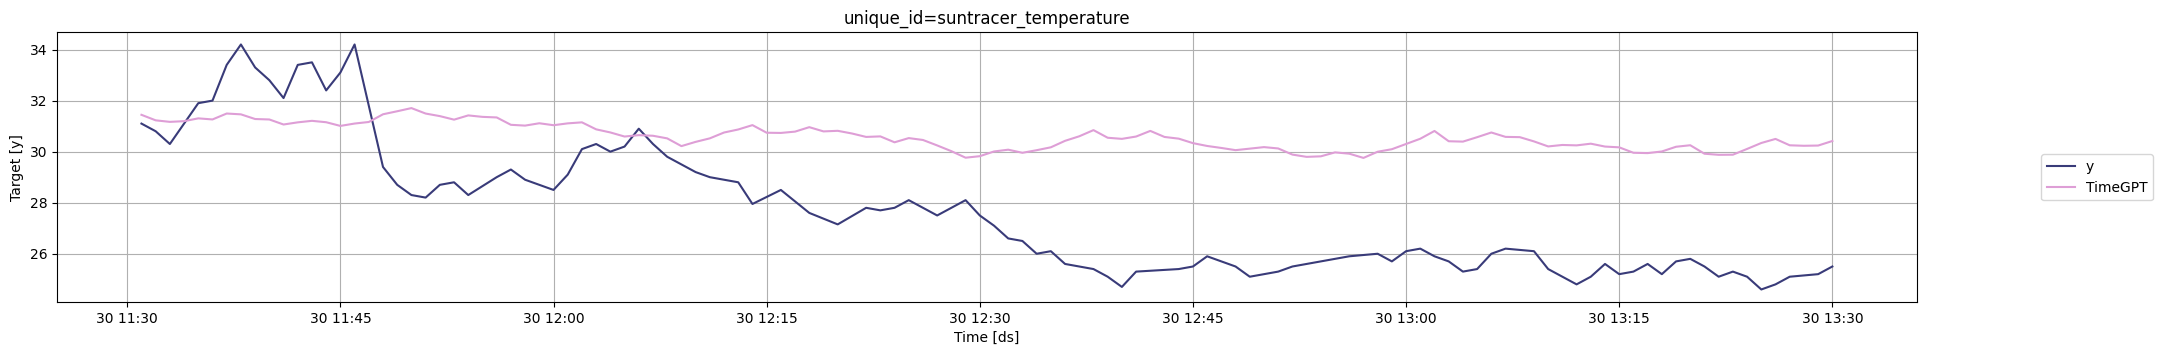

In [140]:
nixtla_client.plot(test_filled[:120], forecast_without_gaps, time_col='ds', target_col='y')

### Evaluación de los modelos

Para comprobar la eficacia obtenida, comprobaremos con las métricas mae, mse y rmse los resultados obtenidos

In [141]:
# Evaluate the model
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse, rmse

In [142]:
forecast_without_gaps['ds'] = pd.to_datetime(forecast_without_gaps['ds'])

results_without_gaps_TimeGPT = completed_df.merge(forecast_without_gaps, on=['ds', 'unique_id'], how='left')
results_without_gaps_TimeGPT['unique_id'] = 'suntracer_temperature_TimeGPT'

In [143]:
forecast['timestamp'] = pd.to_datetime(forecast['timestamp'])

results_TimeGPT = reduced_df.merge(forecast, on=['timestamp'], how='left')
results_TimeGPT.rename(columns={'timestamp': 'ds', 'temperature (Cº)': 'y'}, inplace=True)
results_TimeGPT['unique_id'] = 'suntracer_temperature_TimeGPT'

In [144]:
evaluate(results_without_gaps_TimeGPT, metrics=[mae, mse, rmse])

,unique_id,metric,TimeGPT
0,suntracer_temperature_TimeGPT,mae,3.325080
1,suntracer_temperature_TimeGPT,mse,13.555523
2,suntracer_temperature_TimeGPT,rmse,3.681783


In [145]:
evaluate(results_TimeGPT, metrics=[mae, mse, rmse])

,unique_id,metric,TimeGPT
0,suntracer_temperature_TimeGPT,mae,1.322878
1,suntracer_temperature_TimeGPT,mse,2.805534
2,suntracer_temperature_TimeGPT,rmse,1.674973


## 3. Creación y análsis del modelo con Prophet

Este modelo ha sido entrenado por Meta y se especializa en el análisis y predicciones de series temporales. 

In [146]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

### Creación y entrenamiento del modelo

In [147]:
m = Prophet()
m.fit(train.rename(columns={'timestamp': 'ds', 'temperature (Cº)': 'y'}))

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\IvO\AppData\Local\Temp\tmpvd18pkw5\ermhqax3.json
DEBUG:cmdstanpy:input tempfile: C:\Users\IvO\AppData\Local\Temp\tmpvd18pkw5\ky8pc9nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\IvO\\Desktop\\testGit\\.venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=49965', 'data', 'file=C:\\Users\\IvO\\AppData\\Local\\Temp\\tmpvd18pkw5\\ermhqax3.json', 'init=C:\\Users\\IvO\\AppData\\Local\\Temp\\tmpvd18pkw5\\ky8pc9nz.json', 'output', 'file=C:\\Users\\IvO\\AppData\\Local\\Temp\\tmpvd18pkw5\\prophet_modeli6k5wgxw\\prophet_model-20240720101342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:42 - cmdstanpy - INFO - Chain [1] start processing
INF

In [148]:
train_filled.tail()

,unique_id,ds,y
83636,suntracer_temperature,2023-04-30 11:26:00,34.7
83637,suntracer_temperature,2023-04-30 11:27:00,31.8
83638,suntracer_temperature,2023-04-30 11:28:00,31.0
83639,suntracer_temperature,2023-04-30 11:29:00,31.7
83640,suntracer_temperature,2023-04-30 11:30:00,31.4


### Predicciones con el modelo

Para poder llevar a cabo predicciones en el futuro es necesario ampliar el dataframe original con el método que nos aporta la propia librería. Tras ejecutar el método comprobaremos que se han añadido de forma correcta 120 minutos en el futuro.

In [149]:
future = m.make_future_dataframe(periods=120, freq='min')
future.tail(15)

,ds
57502,2023-04-30 17:23:00
57503,2023-04-30 17:24:00
57504,2023-04-30 17:25:00
57505,2023-04-30 17:26:00
57506,2023-04-30 17:27:00
57507,2023-04-30 17:28:00
57508,2023-04-30 17:29:00
57509,2023-04-30 17:30:00
57510,2023-04-30 17:31:00
57511,2023-04-30 17:32:00


In [150]:
forecast_prophet = m.predict(future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
57512,2023-04-30 17:33:00,23.516289,21.010801,25.896347
57513,2023-04-30 17:34:00,23.484447,20.902983,26.156875
57514,2023-04-30 17:35:00,23.452807,20.780342,25.839435
57515,2023-04-30 17:36:00,23.421372,20.808960,25.841123
57516,2023-04-30 17:37:00,23.390143,20.950039,25.674780


### Resultados obtenidos

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',

  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



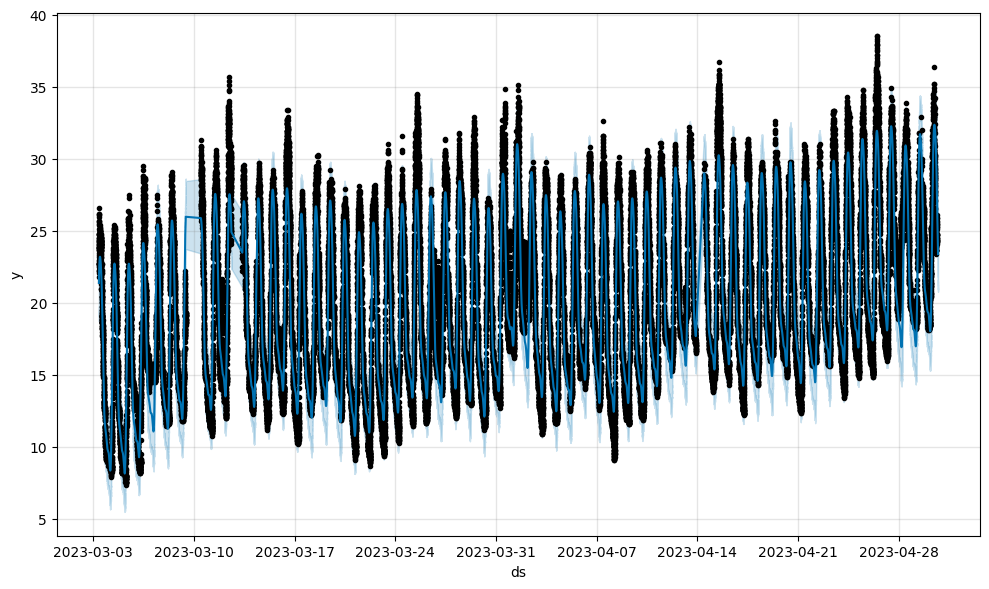

In [151]:
fig1 = m.plot(forecast_prophet)

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',

  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\te

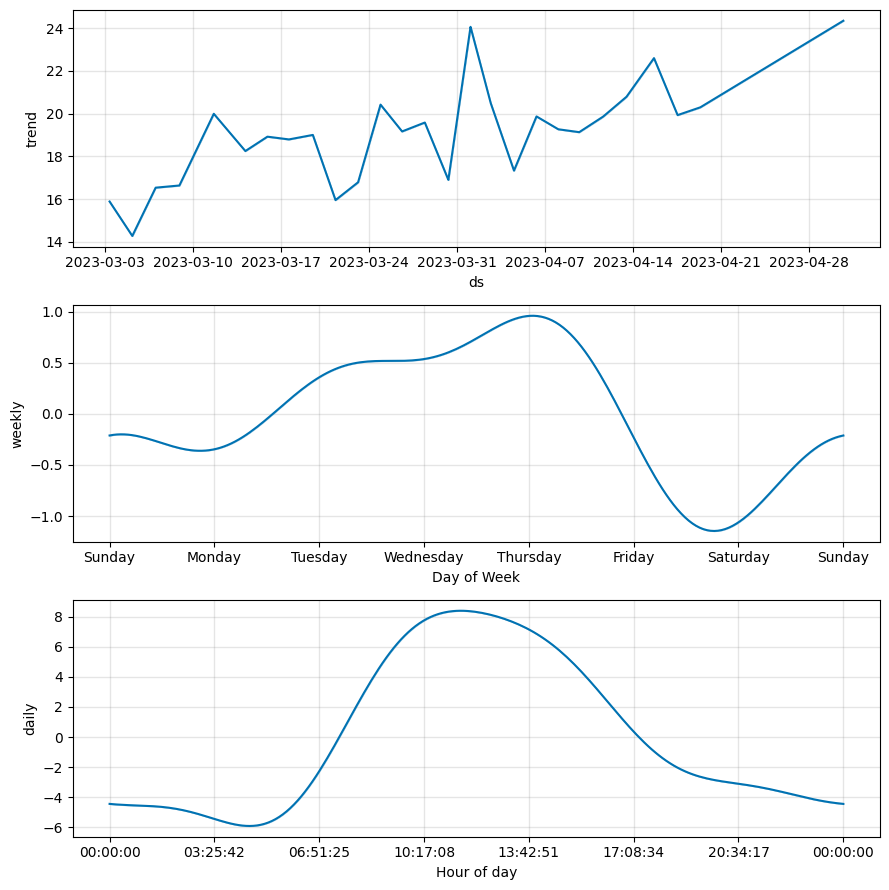

In [152]:
fig2 = m.plot_components(forecast_prophet)

## 4. Creación y análsis del modelo con NeuralProphet

Dentro del enlace https://facebook.github.io/prophet/docs/additional_topics.html#saving-models, los desarolladores anuncian que no continuarán con el desarrollo de Prophet, ofreciendo otras alternativas para lograr predicciones tan precisas como las existentes en el estado del arte. Una de estas alternativas es NeuralProphet, que supone una adaptación y extensión de este modelo implementado en PyTorch.

In [153]:
#https://facebook.github.io/prophet/docs/additional_topics.html#saving-models
from neuralprophet import NeuralProphet

### Creación y entrenamiento del modelo

In [182]:
neuralProphet_df = completed_df.copy()
neuralProphet_df.rename(columns={'timestamp': 'ds', 'temperature (Cº)': 'y'}, inplace=True)
neuralProphet_df = neuralProphet_df[['ds', 'y']]
neuralProphet_df.head()

,ds,y
0,2023-03-03 09:30:00,22.7
1,2023-03-03 09:31:00,22.2
2,2023-03-03 09:32:00,21.8
3,2023-03-03 09:33:00,22.1
4,2023-03-03 09:34:00,22.6


In [190]:
n = NeuralProphet()
# Uncomment this line if you're on a Jupyter notebook
# n.set_plotting_backend('plotly-static')
n_metrics = n.fit(neuralProphet_df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency min corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency min corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as min
INFO:NP.df_utils:Dataframe freq automatically defined as min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dat

Finding best initial lr:   0%|          | 0/275 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [191]:
forecast_neural = n.predict(neuralProphet_df)

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency min corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency min corresponds to 99.999% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Deskt

Predicting: 409it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [192]:
n.plot(forecast_neural)

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~2h</i>',
              'type': 'scatter',
              'uid': 'c84c7ed9-0053-4322-8ab2-d789f2ee3d2a',
              'x': array([datetime.datetime(2023, 3, 3, 9, 30),
                          datetime.datetime(2023, 3, 3, 11, 15),
                          datetime.datetime(2023, 3, 3, 12, 10), ...,
                          datetime.datetime(2023, 5, 14, 20, 30),
                          datetime.datetime(2023, 5, 14, 22, 15),
                          datetime.datetime(2023, 5, 15, 0, 0)], dtype=object),
              'y': array([20.126575, 21.583193, 21.654123, ..., 19.016363, 18.270477, 17.83002 ],
                         dtype=float32)},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
          

In [186]:
n.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~2h</i>',
              'type': 'scatter',
              'uid': '62b91f4a-4455-4856-bf20-3add8f995e59',
              'x': array([datetime.datetime(2023, 3, 3, 9, 30),
                          datetime.datetime(2023, 3, 3, 11, 15),
                          datetime.datetime(2023, 3, 3, 11, 16), ...,
                          datetime.datetime(2023, 5, 14, 20, 29),
                          datetime.datetime(2023, 5, 14, 22, 15),
                          datetime.datetime(2023, 5, 15, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([13.45452953, 13.52473907, 13.52540773, ..., 22.06565675, 22.05925673,
                          22.05291708]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              

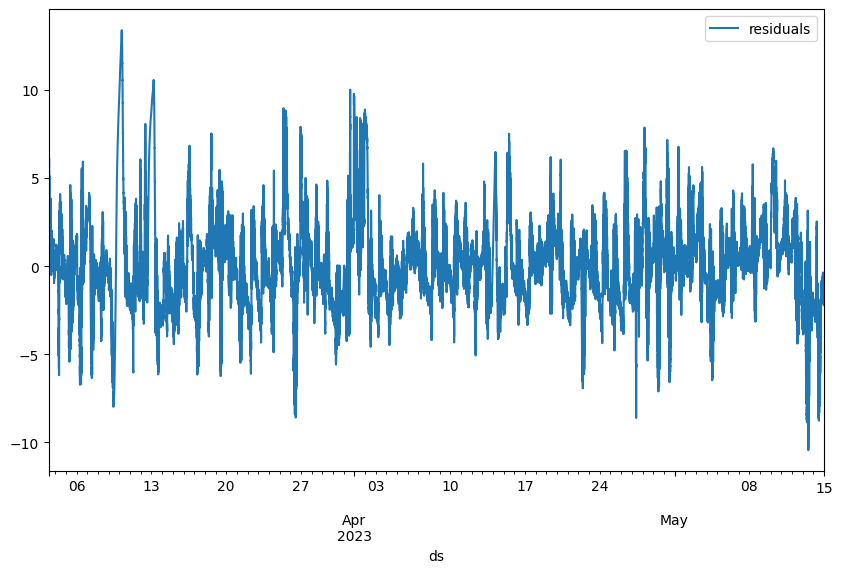

In [193]:
df_residuals = pd.DataFrame({"ds": neuralProphet_df["ds"], "residuals": neuralProphet_df["y"] - forecast_neural["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

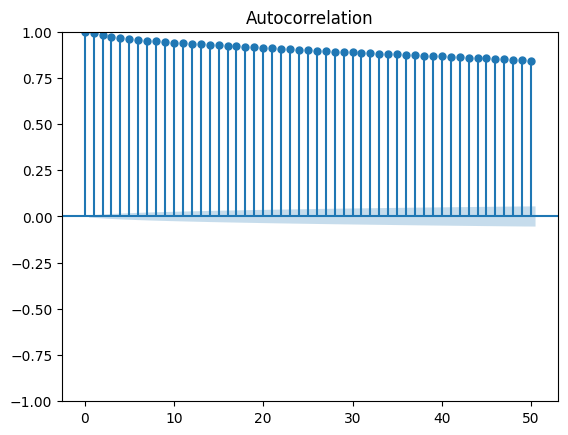

In [194]:
from statsmodels.graphics.tsaplots import plot_acf

plt = plot_acf(df_residuals["residuals"], lags=50)

In [198]:
# Mejoramos el modelo con Autoregresión y uncertainty
n = NeuralProphet(n_lags=10, quantiles=[0.05, 0.95])
n_metrics = n.fit(neuralProphet_df)
forecast_neural = n.predict(neuralProphet_df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency min corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency min corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as min
INFO:NP.df_utils:Dataframe freq automatically defined as min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dat

Finding best initial lr:   0%|          | 0/275 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency min corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency min corresponds to 99.999% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Deskt

Predicting: 409it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [201]:
n.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast_neural)

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




FigureWidgetResampler({
    'data': [{'fillcolor': 'rgba(45, 146, 255, 0.2)',
              'line': {'color': 'rgba(45, 146, 255, 0.2)', 'width': 1},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 5.0% <i style="color:#fc9944">~2h</i>',
              'type': 'scatter',
              'uid': 'e0fa816e-cc3f-41f0-bf66-b570dd8e0d48',
              'x': array([datetime.datetime(2023, 3, 3, 9, 30),
                          datetime.datetime(2023, 3, 3, 9, 49),
                          datetime.datetime(2023, 3, 3, 12, 34), ...,
                          datetime.datetime(2023, 5, 14, 21, 43),
                          datetime.datetime(2023, 5, 14, 22, 8),
                          datetime.datetime(2023, 5, 15, 0, 0)], dtype=object),
              'y': array([      nan, 25.529795, 23.86684 , ..., 17.925385, 16.750256, 15.837334],
                         dtype=float32)},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(45, 1

### Validación y evaluación

In [ ]:
# Train and Validation
prophet_test_rows = int(len(neuralProphet_df)*separation_grade)

test_prophet = neuralProphet_df.tail(prophet_test_rows)
train_prophet = neuralProphet_df.apply(lambda x: x.iloc[:-prophet_test_rows]).reset_index(drop=True)
train_prophet.tail()

,ds,y
83636,2023-04-30 11:26:00,34.7
83637,2023-04-30 11:27:00,31.8
83638,2023-04-30 11:28:00,31.0
83639,2023-04-30 11:29:00,31.7
83640,2023-04-30 11:30:00,31.4


In [ ]:
test_prophet.head()

,ds,y
83641,2023-04-30 11:31:00,31.1
83642,2023-04-30 11:32:00,30.8
83643,2023-04-30 11:33:00,30.3
83644,2023-04-30 11:34:00,31.1
83645,2023-04-30 11:35:00,31.9


In [ ]:
n_validator = NeuralProphet()
n_metrics = n_validator.fit(train_prophet)
n_metrics_test = n_validator.test(test_prophet)
n_metrics_test

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency min corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency min corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as min
INFO:NP.df_utils:Dataframe freq automatically defined as min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dat

Finding best initial lr:   0%|          | 0/273 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency min corresponds to 99.995% of the data.
INFO:NP.df_utils:Major frequency min corresponds to 99.995% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Deskt

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.03956601023674011    │
│          MAE_val          │     2.558817148208618     │
│         RMSE_val          │    2.9001903533935547     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,2.558817,2.90019,0.039566,0.0


In [ ]:
n_metrics_test.plot()

In [ ]:
# Hacer predicciones en el futuro
future = n.make_future_dataframe(neuralProphet_df, periods=120)
forecast_future = n.predict(future)
forecast_future.tail()

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency min corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency min corresponds to 99.999% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Deskt

Predicting: 409it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,season_weekly,season_daily
6,2023-05-14 23:57:00,16.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2023-05-14 23:58:00,16.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-05-14 23:59:00,16.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-05-15 00:00:00,16.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2023-05-15 00:01:00,NaN,15.969152,15.855341,16.130325,25.563711,-3.868505,-2.602669,-3.123385


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [161]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [162]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        y.append(df.iloc[(i+window_size):(i+window_size+target_size)].values)
    return np.array(X), np.array(y)

In [164]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(reduced_df['temperature (Cº)'], WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((71671, 60), (71671, 15))

In [165]:
X

array([[22.7, 22.2, 21.8, ..., 23.9, 23.5, 23.3],
       [22.2, 21.8, 22.1, ..., 23.5, 23.3, 23.9],
       [21.8, 22.1, 22.6, ..., 23.3, 23.9, 23.3],
       ...,
       [17.9, 18. , 18.1, ..., 15.9, 16. , 16.1],
       [18. , 18.1, 17.9, ..., 16. , 16.1, 16.2],
       [18.1, 17.9, 18. , ..., 16.1, 16.2, 16. ]])

In [166]:
y

array([[23.9, 23.3, 23.2, ..., 24.6, 25.1, 25. ],
       [23.3, 23.2, 23. , ..., 25.1, 25. , 24.5],
       [23.2, 23. , 23.2, ..., 25. , 24.5, 24.4],
       ...,
       [16.2, 16. , 15.8, ..., 15.9, 15.7, 15.8],
       [16. , 15.8, 15.9, ..., 15.7, 15.8, 16. ],
       [15.8, 15.9, 15.8, ..., 15.8, 16. , 16.1]])

In [167]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(57336, 14335, 57336, 14335)

In [168]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1)))
HandMadeLSTM.add(Dense(TARGET_SIZE))

HandMadeLSTM.summary()

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,871 (69.81 KB)

 Trainable params: 17,871 (69.81 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
modelPath = 'LSMTTensorflow/bestModel.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [170]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 27765.1953 - mean_absolute_error: 31.0154 - root_mean_squared_error: 152.1250 - val_loss: 5.6245 - val_mean_absolute_error: 1.7961 - val_root_mean_squared_error: 2.3716
Epoch 2/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 4.6049 - mean_absolute_error: 1.6743 - root_mean_squared_error: 2.1457 - val_loss: 4.4906 - val_mean_absolute_error: 1.5768 - val_root_mean_squared_error: 2.1191
Epoch 3/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 3.7051 - mean_absolute_error: 1.4368 - root_mean_squared_error: 1.9236 - val_loss: 2.3316 - val_mean_absolute_error: 1.0988 - val_root_mean_squared_error: 1.5270
Epoch 4/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 1.9509 - mean_absolute_error: 0.9882 - root_mean_squared_error: 1.3960 - val_loss: 1.5545 - val_mean_absolute_error: 0.8667 - val_root_mean_squared_error: 1.2468
Epoch 5/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 1.4232 - mean_absolute_er

In [171]:
HandMadeLSTM = load_model(modelPath)

1792/1792 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


<Axes: >

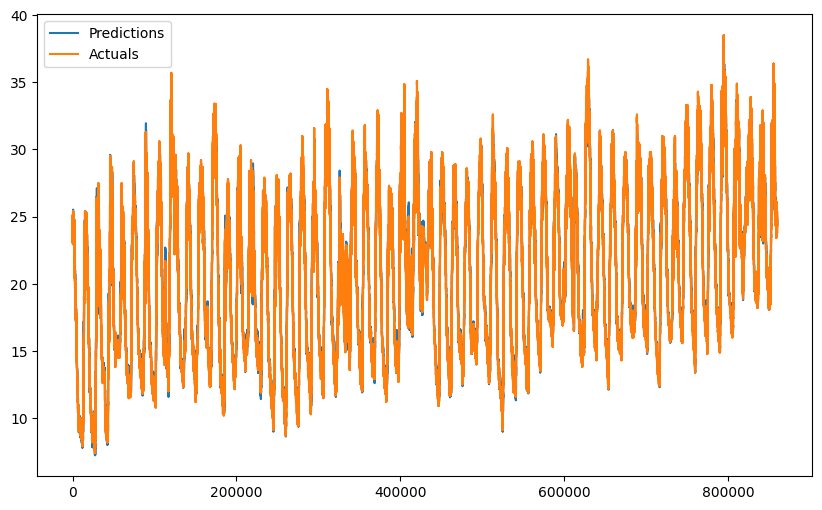

In [172]:
train_predictions = HandMadeLSTM.predict(X_train).flatten()
train_results_LSTM = pd.DataFrame(data={'Predictions': train_predictions, 'Actuals': y_train.flatten()})
train_results_LSTM.plot(figsize=(10,6))

In [174]:
train_results_LSTM.tail(15)

,Predictions,Actuals
860025,24.419605,25.3
860026,24.829828,25.4
860027,24.785608,24.6
860028,24.818861,24.0
860029,24.668671,23.9
860030,24.740675,24.1
860031,24.549496,24.2
860032,24.758276,23.9
860033,24.478468,24.0
860034,24.568666,23.8


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<Axes: >

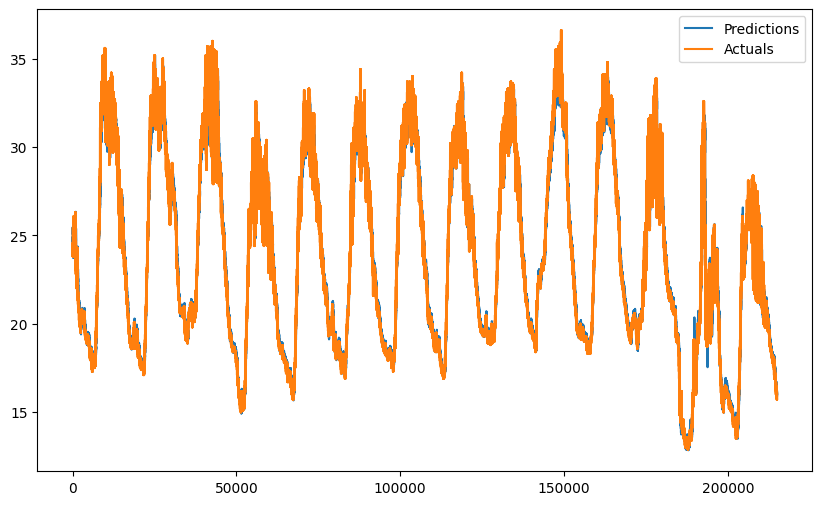

In [175]:
test_predictions = HandMadeLSTM.predict(X_test).flatten()
test_results_LSTM = pd.DataFrame(data={'Predictions': test_predictions, 'Actuals': y_test.flatten()})
test_results_LSTM.plot(figsize=(10,6))

In [176]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Train MSE:', mean_squared_error(y_train.flatten(), train_predictions))
print('Train MAE:', mean_absolute_error(y_train.flatten(), train_predictions))
print('Test MSE:', mean_squared_error(y_test.flatten(), test_predictions))
print('Test MAE:', mean_absolute_error(y_test.flatten(), test_predictions))

Train MSE: 0.8968093190498823
Train MAE: 0.6233390480044564
Test MSE: 0.935330185057611
Test MAE: 0.6377134433715735


In [177]:
train_results_LSTM['unique_id'] = 'suntracer_temperature_LSMT'
test_results_LSTM['unique_id'] = 'suntracer_temperature_LSMT'
evaluate(train_results_LSTM, target_col='Predictions', metrics=[mae, mse, rmse])

,unique_id,metric,Actuals
0,suntracer_temperature_LSMT,mae,0.623339
1,suntracer_temperature_LSMT,mse,0.896809
2,suntracer_temperature_LSMT,rmse,0.947000


In [178]:
evaluate(test_results_LSTM, target_col='Predictions', metrics=[mae, mse, rmse])

,unique_id,metric,Actuals
0,suntracer_temperature_LSMT,mae,0.637713
1,suntracer_temperature_LSMT,mse,0.935330
2,suntracer_temperature_LSMT,rmse,0.967125


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [179]:
horizons = [60, 360, 720]

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Epoch 1/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 88.3770 - mean_absolute_error: 5.6111 - root_mean_squared_error: 8.5049 - val_loss: 3.5434 - val_mean_absolute_error: 1.3496 - val_root_mean_squared_error: 1.8824
Epoch 2/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4645 - mean_absolute_error: 1.3014 - root_mean_squared_error: 1.8611 - val_loss: 3.6230 - val_mean_absolute_error: 1.3385 - val_root_mean_squared_error: 1.9034
Epoch 3/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4349 - mean_absolute_error: 1.2966 - root_mean_squared_error: 1.8533 - val_loss: 3.5962 - val_mean_absolute_error: 1.4287 - val_root_mean_squared_error: 1.8964
Epoch 4/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - loss: 3.4386 - mean_absolute_error: 1.3042 - root_mean_squared_error: 1.8543 - val_loss: 3.7422 - val_mean_absolute_error: 1.3320 - val_root_mean_squared_error: 1.9345
Epoch 5/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4347 - mean_absolute_error: 1.2985 - 

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Epoch 1/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 118.6560 - mean_absolute_error: 7.9755 - root_mean_squared_error: 10.3635 - val_loss: 27.4893 - val_mean_absolute_error: 4.0260 - val_root_mean_squared_error: 5.2430
Epoch 2/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 24.0400 - mean_absolute_error: 3.9927 - root_mean_squared_error: 4.9026 - val_loss: 26.2206 - val_mean_absolute_error: 3.8882 - val_root_mean_squared_error: 5.1206
Epoch 3/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 22.8662 - mean_absolute_error: 3.8488 - root_mean_squared_error: 4.7818 - val_loss: 27.3901 - val_mean_absolute_error: 3.9131 - val_root_mean_squared_error: 5.2336
Epoch 4/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 22.7902 - mean_absolute_error: 3.8342 - root_mean_squared_error: 4.7739 - val_loss: 29.4314 - val_mean_absolute_error: 4.0014 - val_root_mean_squared_error: 5.4251
Epoch 5/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 22.8325 - mean_absolute_error: 3

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Epoch 1/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 135.1770 - mean_absolute_error: 9.0926 - root_mean_squared_error: 11.1598 - val_loss: 36.4566 - val_mean_absolute_error: 4.8134 - val_root_mean_squared_error: 6.0379
Epoch 2/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 24.1812 - mean_absolute_error: 3.9960 - root_mean_squared_error: 4.9174 - val_loss: 37.6831 - val_mean_absolute_error: 4.8670 - val_root_mean_squared_error: 6.1387
Epoch 3/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 24.1790 - mean_absolute_error: 3.9831 - root_mean_squared_error: 4.9172 - val_loss: 39.2451 - val_mean_absolute_error: 4.9239 - val_root_mean_squared_error: 6.2646
Epoch 4/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 24.0614 - mean_absolute_error: 3.9690 - root_mean_squared_error: 4.9052 - val_loss: 35.1297 - val_mean_absolute_error: 4.6862 - val_root_mean_squared_error: 5.9270
Epoch 5/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 23.8995 - mean_absolute_error: 3

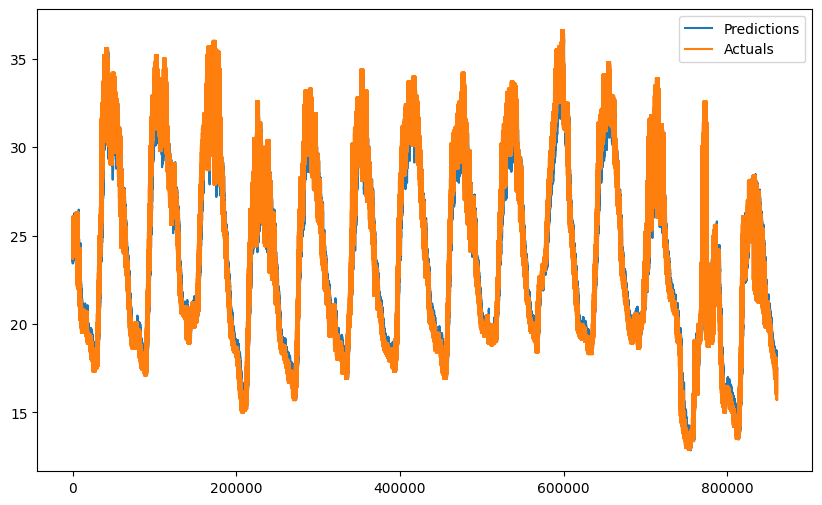

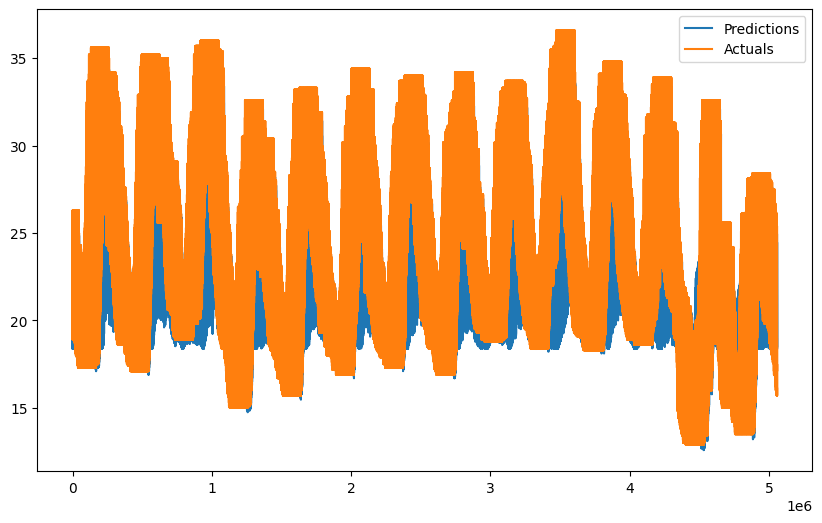

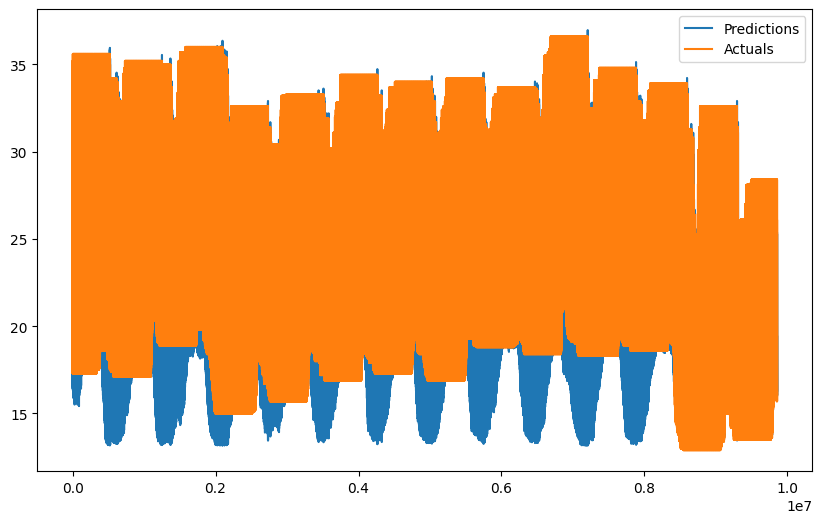

In [181]:
for horizon in horizons:
    X, y = split_sequence(reduced_df['temperature (Cº)'], 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(LSTM(64, activation='relu', input_shape=(1, 1)))
    HandMadeLSTM.add(Dense(horizon))

    modelPath = f'LSMTTensorflow/bestModel_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    train_predictions = HandMadeLSTM.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Predictions': train_predictions, 'Actuals': y_train.flatten()})
    print(f'Train results for horizon {horizon}')
    print('Train MSE:', mean_squared_error(y_train.flatten(), train_predictions))
    print('Train MAE:', mean_absolute_error(y_train.flatten(), train_predictions))

    test_predictions = HandMadeLSTM.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Predictions': test_predictions, 'Actuals': y_test.flatten()})
    print(f'Test results for horizon {horizon}')
    print('Test MSE:', mean_squared_error(y_test.flatten(), test_predictions))
    print('Test MAE:', mean_absolute_error(y_test.flatten(), test_predictions))

    test_results.plot(figsize=(10,6))

##  6. Análisis de resultados y modelo a usar.

Aunque en cada uno de los apartados se han presentado los resultados y evaluaciones con los datos de entrenamiento y prueba, recogemos en este apartado final todos los resultados para decantarnos por un modelo.

### LSMT

In [167]:
LSMT_evaluation = evaluate(test_results_LSTM, target_col='Predictions', metrics=[mae, mse, rmse])
LSMT_evaluation

,unique_id,metric,Actuals
0,suntracer_temperature_LSMT,mae,0.503695
1,suntracer_temperature_LSMT,mse,0.673064
2,suntracer_temperature_LSMT,rmse,0.820405


### Prophet

In [132]:
n_metrics_test

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,2.558817,2.90019,0.039566,0.0


### TimeGTP

In [135]:
evaluate(results_without_gaps_TimeGPT, metrics=[mae, mse, rmse])

,unique_id,metric,TimeGPT
0,suntracer_temperature_TimeGPT,mae,3.300436
1,suntracer_temperature_TimeGPT,mse,13.319867
2,suntracer_temperature_TimeGPT,rmse,3.649639


In [165]:
timeGPT_evaluation = evaluate(results_TimeGPT, metrics=[mae, mse, rmse])
timeGPT_evaluation

,unique_id,metric,TimeGPT
0,suntracer_temperature_TimeGPT,mae,1.340534
1,suntracer_temperature_TimeGPT,mse,2.846650
2,suntracer_temperature_TimeGPT,rmse,1.687202


## Comparativa en misma tabla

In [171]:
final_results = pd.concat([LSMT_evaluation, timeGPT_evaluation, n_metrics_test])
final_results

,unique_id,metric,Actuals,TimeGPT,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,suntracer_temperature_LSMT,mae,0.503695,NaN,NaN,NaN,NaN,NaN
1,suntracer_temperature_LSMT,mse,0.673064,NaN,NaN,NaN,NaN,NaN
2,suntracer_temperature_LSMT,rmse,0.820405,NaN,NaN,NaN,NaN,NaN
0,suntracer_temperature_TimeGPT,mae,NaN,1.340534,NaN,NaN,NaN,NaN
1,suntracer_temperature_TimeGPT,mse,NaN,2.846650,NaN,NaN,NaN,NaN
2,suntracer_temperature_TimeGPT,rmse,NaN,1.687202,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,2.558817,2.90019,0.039566,0.0


**Debido a presentar el menor valor de error, se ha optado por desarrollar los modelos restantes haciendo uso de LSMT**